# Data Processing

In this notebook, we will prepare the dataset for modeling.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**A. Data daily**

**1. Overview of Data after Data Understanding**

In [2]:
# Load the dataset
df_daily = pd.read_excel(r'../data/processed/data_daily_after_basic_understand.xlsx')

In [3]:
# Xác định loại dữ liệu
numerical_features = df_daily.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_daily.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numerical_features)
print("Categorical features:", categorical_features)

Numeric features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical features: ['conditions', 'description', 'icon', 'stations']


In [4]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])
df_daily = df_daily.sort_values('datetime').reset_index(drop=True)

**2. Drop missing columns**


In [5]:
# Kiểm tra missing values và duplicates
print("Số lượng giá trị thiếu:\n", df_daily.isnull().sum())
print("\nTỷ lệ thiếu (%):\n", (df_daily.isnull().mean() * 100).round(2))

dupes_daily = df_daily.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dupes_daily}")

Số lượng giá trị thiếu:
 datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipcover            0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2566
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

Tỷ lệ thiếu (%):
 datetime             0.00
tempmax              0.00
tempmin              0.00
temp                 0.00
feelslikemax         0.00
feelslikemin         0.00
feelslike            0.00
dew                  0.00
humidity             0.00
precip   

During the data exploration process, I observed that **only the `severerisk` column contains missing values**, with a **missing rate as high as 65.34%**. Such a high proportion of missing data suggests that the column provides limited informational value and may negatively impact model performance if retained. Furthermore, correlation analysis shows that `severerisk` has little to no relationship with the target variable. Keeping it would add noise rather than value to the model.  

Given the high missing rate, weak correlation, and lack of statistical reliability,  
the `severerisk` column will be **dropped** from the dataset prior to feature engineering and model training.

In [6]:
# Loại bỏ cột severisk
df_daily = df_daily.drop(columns=['severerisk'])
# Kiểm tra lại kết quả
print("Kích thước dữ liệu sau khi drop cột 'severerisk':", df_daily.shape)

Kích thước dữ liệu sau khi drop cột 'severerisk': (3927, 27)


**3. Train-test split**

In [7]:
# Chia train-test split theo thời gian, trong đó khoảng cách tập train và test là 7 ngày để tránh data leakage do tính chất thời gian của dữ liệu, temp là biến mục tiêu
train_size = int(len(df_daily) * 0.8)
# Tập huấn luyện kết thúc trước 7 ngày so với tập kiểm tra
train_data = df_daily.iloc[:train_size] 
# Tập kiểm tra bắt đầu từ ngày thứ 7 sau tập huấn luyện đến hết
test_data = df_daily.iloc[train_size:]
print(f"Kích thước tập huấn luyện: {train_data.shape}")
print(f"Kích thước tập kiểm tra: {test_data.shape}")
print(f"Khoảng thời gian tập huấn luyện: {train_data['datetime'].min()} đến {train_data['datetime'].max()}")
print(f"Khoảng thời gian tập kiểm tra: {test_data['datetime'].min()} đến {test_data['datetime'].max()}")

# temp là biến mục tiêu
feature_cols = df_daily.columns.drop(['temp', 'datetime'])  # Loại bỏ cột temp khỏi features
X_train = train_data[feature_cols]
y_train = train_data['temp']
X_test = test_data[feature_cols]
y_test = test_data['temp']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Kích thước tập huấn luyện: (3141, 27)
Kích thước tập kiểm tra: (786, 27)
Khoảng thời gian tập huấn luyện: 2015-01-01 00:00:00 đến 2023-08-07 00:00:00
Khoảng thời gian tập kiểm tra: 2023-08-08 00:00:00 đến 2025-10-01 00:00:00
X_train shape: (3141, 25), y_train shape: (3141,)
X_test shape: (786, 25), y_test shape: (786,)


**4. Observing and handling outliers**

In [8]:
# # Phát hiện outliers bằng phương pháp IQR
numeric_cols_d = df_daily.select_dtypes(include=[np.number]).columns

Q1_d = df_daily[numeric_cols_d].quantile(0.25)
Q3_d = df_daily[numeric_cols_d].quantile(0.75)
IQR_d = Q3_d - Q1_d

outliers_d = ((df_daily[numeric_cols_d] < (Q1_d - 1.5 * IQR_d)) | 
              (df_daily[numeric_cols_d] > (Q3_d + 1.5 * IQR_d))).sum()

print("Số lượng outliers (theo từng cột):\n", outliers_d)

Số lượng outliers (theo từng cột):
 tempmax               3
tempmin               1
temp                  2
feelslikemax          0
feelslikemin         20
feelslike             0
dew                  41
humidity             91
precip              639
precipcover         169
windgust            117
windspeed            59
winddir             664
sealevelpressure      1
cloudcover            0
visibility          119
solarradiation        0
solarenergy           0
uvindex               0
moonphase             0
dtype: int64


In [9]:
# # Xử lý outliers  cho từng tập
# def cap_outliers_iqr(df):
#     df_capped = df.copy()
#     numeric_cols = df_capped.select_dtypes(include=[np.number]).columns

#     for col in numeric_cols:
#         Q1 = df_capped[col].quantile(0.25)
#         Q3 = df_capped[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - 1.5 * IQR
#         upper = Q3 + 1.5 * IQR
#         df_capped[col] = np.where(df_capped[col] < lower, lower,
#                                   np.where(df_capped[col] > upper, upper, df_capped[col]))
#     return df_capped


# # Áp dụng cho từng tập
# X_train_capped = cap_outliers_iqr(X_train)
# X_test_capped = cap_outliers_iqr(X_test)

# print(f"Train shape: {X_train_capped.shape}, Test shape: {X_test_capped.shape}")

In [10]:
# # Kiểm tra lại số lượng outliers sau khi xử lý theo IQR
# def count_outliers_iqr(df):
#     numeric_cols = df.select_dtypes(include=[np.number]).columns
#     Q1 = df[numeric_cols].quantile(0.25)
#     Q3 = df[numeric_cols].quantile(0.75)
#     IQR = Q3 - Q1
#     outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
#                 (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
#     return outliers

# # Đếm outliers sau xử lý
# outliers_train_after = count_outliers_iqr(X_train_capped)
# outliers_test_after = count_outliers_iqr(X_test_capped)

# print("Số lượng outliers trong tập TRAIN sau xử lý:")
# print(outliers_train_after[outliers_train_after > 0])

# print("\nSố lượng outliers trong tập TEST sau xử lý:")
# print(outliers_test_after[outliers_test_after > 0])


In [11]:
# # So sánh trước và sau xử lý
# outliers_before = count_outliers_iqr(X_train)
# outliers_after = count_outliers_iqr(X_train_capped)

# compare = pd.DataFrame({
#     'Before': outliers_before,
#     'After': outliers_after
# })
# print(compare[compare['Before'] > 0])

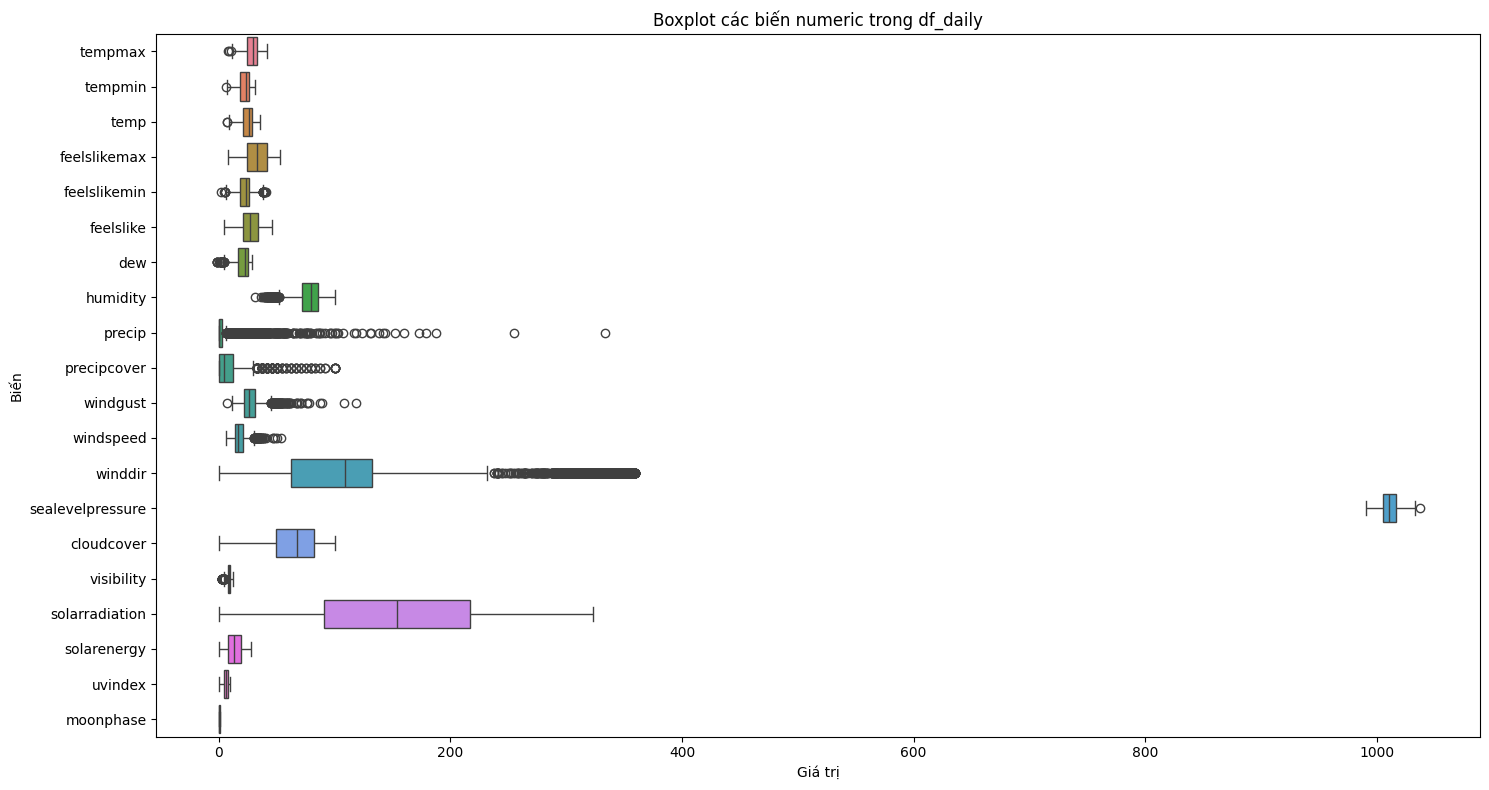

In [12]:
numeric_cols_d = df_daily.select_dtypes(include=['number']).columns

# Vẽ boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_daily[numeric_cols_d], orient='h', showfliers=True)
plt.title("Boxplot các biến numeric trong df_daily")
plt.xlabel("Giá trị")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

In [13]:
# Ma trận tương quan
corr = df_daily.corr(numeric_only=True)
print(corr)

                   tempmax   tempmin      temp  feelslikemax  feelslikemin  \
tempmax           1.000000  0.909259  0.977722      0.964647      0.889029   
tempmin           0.909259  1.000000  0.969581      0.910259      0.963060   
temp              0.977722  0.969581  1.000000      0.957785      0.942461   
feelslikemax      0.964647  0.910259  0.957785      1.000000      0.899939   
feelslikemin      0.889029  0.963060  0.942461      0.899939      1.000000   
feelslike         0.954692  0.942145  0.974478      0.979062      0.951898   
dew               0.843814  0.932995  0.902911      0.866739      0.872035   
humidity          0.011194  0.226346  0.100473      0.097697      0.140572   
precip            0.056500  0.130930  0.090129      0.099973      0.079126   
precipcover       0.061395  0.170696  0.106710      0.094612      0.124118   
windgust          0.126321  0.144815  0.135714      0.119640      0.116548   
windspeed         0.155296  0.155355  0.153572      0.181514    

In [14]:
# Phân loại các cột dựa trên số lượng outliers
def classify_columns_by_outliers(X, outlier_threshold=0.05):
    """
    Phân loại cột numeric thành high outliers và low outliers
    outlier_threshold: tỷ lệ outliers để phân loại (mặc định 5%)
    """
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    Q1 = X[numeric_cols].quantile(0.25)
    Q3 = X[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_counts = ((X[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                      (X[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    outlier_ratios = outlier_counts / len(X)
    
    high_outlier_cols = outlier_ratios[outlier_ratios > outlier_threshold].index.tolist()
    low_outlier_cols = outlier_ratios[outlier_ratios <= outlier_threshold].index.tolist()
    
    return high_outlier_cols, low_outlier_cols, outlier_ratios

# Phân loại cột cho dữ liệu daily
high_outlier_cols, low_outlier_cols, outlier_ratios = classify_columns_by_outliers(X_train, outlier_threshold=0.05)

print("=== Phân loại cột dựa trên outliers ===")
print(f"\nCột có nhiều outliers (>5%): {high_outlier_cols}")
print(f"\nCột có ít outliers (<=5%): {low_outlier_cols}")
print(f"\nTỷ lệ outliers chi tiết:\n{outlier_ratios.sort_values(ascending=False)}")

# Xác định cột categorical
nominal_cols = X_train.select_dtypes(include=['object']).columns.tolist()
ordinal_cols = []  # Nếu có cột ordinal, khai báo ở đây

print(f"\nCột nominal: {nominal_cols}")
print(f"Cột ordinal: {ordinal_cols}")

=== Phân loại cột dựa trên outliers ===

Cột có nhiều outliers (>5%): ['precip', 'winddir']

Cột có ít outliers (<=5%): ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']

Tỷ lệ outliers chi tiết:
winddir             0.167144
precip              0.165234
precipcover         0.037886
windgust            0.028972
visibility          0.027698
humidity            0.020694
windspeed           0.012735
cloudcover          0.010825
dew                 0.009869
feelslikemin        0.006049
tempmax             0.000637
sealevelpressure    0.000318
tempmin             0.000318
feelslikemax        0.000000
feelslike           0.000000
solarradiation      0.000000
solarenergy         0.000000
uvindex             0.000000
moonphase           0.000000
dtype: float64

Cột nominal: ['conditions', 'description', 'icon', 'sta

In [15]:
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder

# Tách các cột datetime
datetime_cols = X_train.select_dtypes(include=['datetime']).columns.tolist()

# Tách các cột không phải datetime (numeric và categorical)
train_non_datetime = train_data.drop(columns=datetime_cols)
test_non_datetime = test_data.drop(columns=datetime_cols)

# Tạo ColumnTransformer
transformers = []

# 1. RobustScaler cho numeric có nhiều outliers
if high_outlier_cols:
    transformers.append(('robust', RobustScaler(), high_outlier_cols))

# 2. StandardScaler cho numeric có ít outliers
if low_outlier_cols:
    transformers.append(('standard', StandardScaler(), low_outlier_cols))

# 3. OneHotEncoder cho nominal
if nominal_cols:
    transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols))

# 4. OrdinalEncoder cho ordinal (nếu có)
if ordinal_cols:
    transformers.append(('ordinal', OrdinalEncoder(), ordinal_cols))

# Tạo ColumnTransformer (passthrough để giữ nguyên các cột không được transform)
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough', verbose_feature_names_out=False  # Giữ nguyên các cột không được transform
)

# ===== FIT VÀ TRANSFORM =====
print("\n=== Bắt đầu fit và transform dữ liệu ===")
train_transformed = preprocessor.fit_transform(train_non_datetime)

# Transform tập TEST (dùng parameters đã học từ train)
test_transformed = preprocessor.transform(test_non_datetime)

print(f"\nKích thước sau khi transform:")
print(f"  X_train: {train_non_datetime.shape} -> {train_transformed.shape}")
print(f"  X_test: {test_non_datetime.shape} -> {test_transformed.shape}")

# Kết hợp lại các cột datetime vào kết quả cuối cùng
# Đảm bảo rằng các cột datetime sẽ không bị thay đổi
train_transformed = pd.DataFrame(train_transformed)
test_transformed = pd.DataFrame(test_transformed)

# Thêm lại cột datetime vào kết quả cuối cùng
train_transformed[datetime_cols] = train_data[datetime_cols].reset_index(drop=True)
test_transformed[datetime_cols] = test_data[datetime_cols].reset_index(drop=True)

# Hiển thị kết quả
print(f"\nKích thước sau khi thêm cột datetime vào:")
print(f"  X_train: {train_transformed.shape}")
print(f"  X_test: {test_transformed.shape}")


=== Bắt đầu fit và transform dữ liệu ===

Kích thước sau khi transform:
  X_train: (3141, 25) -> (3141, 78)
  X_test: (786, 25) -> (786, 78)

Kích thước sau khi thêm cột datetime vào:
  X_train: (3141, 80)
  X_test: (786, 80)


In [16]:
# ...existing code...
# ===== Sửa lỗi: fit/transform + giữ tên cột + giữ datetime =====
import os
from pandas.api import types as pd_types

# Fit trên dữ liệu không chứa datetime (nếu chưa fit)
preprocessor.fit(train_non_datetime)

train_arr = preprocessor.transform(train_non_datetime)
test_arr = preprocessor.transform(test_non_datetime)

# Tạo tên feature an toàn
try:
    # sklearn >=1.0
    feature_names = list(preprocessor.get_feature_names_out(train_non_datetime.columns))
except Exception:
    feature_names = []
    used_cols = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        cols_list = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else [cols]
        used_cols.extend(cols_list)
        fitted = preprocessor.named_transformers_.get(name, None)
        if fitted is not None and hasattr(fitted, "get_feature_names_out"):
            try:
                out = fitted.get_feature_names_out(cols_list)
                feature_names.extend(list(out))
            except Exception:
                feature_names.extend([f"{name}__{c}" for c in cols_list])
        else:
            feature_names.extend([f"{name}__{c}" for c in cols_list])
    # thêm passthrough nếu có
    if getattr(preprocessor, "remainder", None) == 'passthrough':
        passthrough = [c for c in train_non_datetime.columns if c not in used_cols]
        feature_names.extend(passthrough)

# Fallback nếu mismatch kích thước
if len(feature_names) != train_arr.shape[1]:
    feature_names = [f"feat_{i}" for i in range(train_arr.shape[1])]

# Chuyển về DataFrame và giữ index gốc
train_transformed = pd.DataFrame(train_arr, columns=feature_names, index=train_non_datetime.index)
test_transformed = pd.DataFrame(test_arr, columns=feature_names, index=test_non_datetime.index)

# Lấy cột datetime từ train_data/test_data (giữ dtype)
datetime_cols = [c for c in train_data.columns if pd_types.is_datetime64_any_dtype(train_data[c])]

for dt in datetime_cols:
    # nếu tên datetime vô tình có trong feature_names thì ghi đè bằng giá trị gốc
    train_transformed[dt] = train_data.loc[train_transformed.index, dt].values
    test_transformed[dt] = test_data.loc[test_transformed.index, dt].values

# Đảm bảo thứ tự cột: feature_names (không chứa datetime) + datetime_cols
final_feature_names = [c for c in feature_names if c not in datetime_cols] + datetime_cols
train_transformed = train_transformed[final_feature_names]
test_transformed = test_transformed[final_feature_names]

# Thêm target 'temp' lại vào nếu cần và lưu
train_data_transformed = train_transformed.copy()
train_data_transformed['temp'] = train_data.loc[train_transformed.index, 'temp'].values
test_data_transformed = test_transformed.copy()
test_data_transformed['temp'] = test_data.loc[test_transformed.index, 'temp'].values

save_dir = '../data/processed/'
os.makedirs(save_dir, exist_ok=True)
train_data_transformed.to_excel(save_dir + 'train_data.xlsx', index=False)
test_data_transformed.to_excel(save_dir + 'test_data.xlsx', index=False)
X_train_transformed = train_transformed.copy()
X_test_transformed = test_transformed.copy()
X_train_transformed.to_excel(save_dir + 'X_train.xlsx', index=False)
X_test_transformed.to_excel(save_dir + 'X_test.xlsx', index=False)
# ...existing code...

In [17]:
print(train_transformed.dtypes)

precip                   object
winddir                  object
tempmax                  object
tempmin                  object
feelslikemax             object
                      ...      
stations_VVNB            object
temp                     object
datetime         datetime64[ns]
sunrise          datetime64[ns]
sunset           datetime64[ns]
Length: 80, dtype: object


In [18]:
print(X_train.dtypes)

tempmax                    float64
tempmin                    float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipcover                float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
sunrise             datetime64[ns]
sunset              datetime64[ns]
moonphase                  float64
conditions                  object
description                 object
icon                        object
stations                    object
dtype: object


In [19]:
# # Save the processed data (train_data_transformed / test_data_transformed already created above)
# import os
# save_dir = '../data/processed/'
# os.makedirs(save_dir, exist_ok=True)

# # Save raw copies if needed
# train_data.to_excel(save_dir + 'train_data_raw.xlsx', index=False)
# test_data.to_excel(save_dir + 'test_data_raw.xlsx', index=False)

# # Helper to convert transformed array -> DataFrame with sensible column names
# def to_df(arr, index, fallback_prefix='feature'):
#     if isinstance(arr, np.ndarray):
#         if 'feature_names_out' in globals() and len(feature_names_out) == arr.shape[1]:
#             cols = feature_names_out
#         else:
#             cols = [f'{fallback_prefix}_{i}' for i in range(arr.shape[1])]
#         return pd.DataFrame(arr, columns=cols, index=index)
#     elif isinstance(arr, pd.DataFrame):
#         return arr.copy()
#     else:
#         raise TypeError("Transformed data must be numpy.ndarray or pandas.DataFrame")

# # Convert and save train_data_transformed / test_data_transformed (no X/y combine)
# train_data.to_excel(save_dir + 'train_data.xlsx', index=False)
# test_data.to_excel(save_dir + 'test_data.xlsx', index=False)

# train_data_transformed_df.to_excel(save_dir + 'train_data.xlsx', index=False)
# test_data_transformed_df.to_excel(save_dir + 'test_data.xlsx', index=False)

# # Also keep separate X/y transformed files if available
# if 'X_train_transformed' in globals():
#     X_train_transformed_df = to_df(X_train_transformed, index=X_train.index, fallback_prefix='Xtrain_feat')
#     X_train_transformed_df.to_excel(save_dir + 'X_train.xlsx', index=False)
# if 'X_test_transformed' in globals():
#     X_test_transformed_df = to_df(X_test_transformed, index=X_test.index, fallback_prefix='Xtest_feat')
#     X_test_transformed_df.to_excel(save_dir + 'X_test.xlsx', index=False)

# # Save y as before
# y_train_series = y_train.squeeze() if isinstance(y_train, pd.DataFrame) else y_train
# y_test_series = y_test.squeeze() if isinstance(y_test, pd.DataFrame) else y_test
# if y_train_series.name is None:
#     y_train_series.name = 'temp'
# if y_test_series.name is None:
#     y_test_series.name = 'temp'
# y_train_series.to_frame().to_excel(save_dir + 'y_train.xlsx', index=False)
# y_test_series.to_frame().to_excel(save_dir + 'y_test.xlsx', index=False)
# # ...existing code...

In [20]:
print(train_transformed.dtypes)

precip                   object
winddir                  object
tempmax                  object
tempmin                  object
feelslikemax             object
                      ...      
stations_VVNB            object
temp                     object
datetime         datetime64[ns]
sunrise          datetime64[ns]
sunset           datetime64[ns]
Length: 80, dtype: object


In [21]:
feature_cols = train_transformed.columns.drop(['temp', 'datetime']) 
X_train_transformed = train_transformed[feature_cols]
y_train_transformed = train_transformed['temp']
X_test_transformed = test_transformed[feature_cols]
y_test_transformed = test_transformed['temp']

In [22]:
# Save the processed data
save_dir = '../data/processed/'
train_transformed.to_excel(save_dir + 'train_data.xlsx', index=False)
test_transformed.to_excel(save_dir + 'test_data.xlsx', index=False)
X_train_transformed.to_excel(save_dir + 'X_train.xlsx', index=False)
y_train_transformed.to_excel(save_dir + 'y_train.xlsx', index=False)
X_test_transformed.to_excel(save_dir + 'X_test.xlsx', index=False)
y_test_transformed.to_excel(save_dir + 'y_test.xlsx', index=False)

In [23]:
print(train_data.dtypes)

datetime            datetime64[ns]
tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipcover                float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
sunrise             datetime64[ns]
sunset              datetime64[ns]
moonphase                  float64
conditions                  object
description                 object
icon                        object
stations                    object
dtype: object


## Huấn luyện mô hình với pipeline tự động  

Trong phần này chúng ta sẽ xây dựng pipeline tiền xử lý + chọn đặc trưng + mô hình, rồi huấn luyện trên `X_train`/`y_train` đã được chia ở trên và đánh giá trên `X_test`/`y_test`.  

Luồng thực hiện:  
- Bước 1: IQR-based outlier handling (đã làm wrapper trong `src/models/pipeline.py`).  
- Bước 2: ColumnTransformer: RobustScaler cho các numeric có nhiều outliers, StandardScaler cho numeric ít outliers, OneHotEncoder cho nominal, OrdinalEncoder cho ordinal.  
- Bước 3: SelectKBest (f_regression) để chọn K đặc trưng (heuristic nếu không truyền vào).  
- Bước 4: Huấn luyện estimator (mặc định RandomForestRegressor).  

Model cuối cùng sẽ được lưu ở `../results/models/pipeline_model.joblib`.  
Nếu bạn muốn điều chỉnh tham số (ví dụ `select_k`, `outlier_threshold`), sửa trực tiếp trong ô code bên dưới.

In [24]:
# # Train pipeline using build_pipeline from src.models.pipeline
# import os
# import joblib
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score
# import sys
# from pathlib import Path
# sys.path.append(str(Path('..').resolve()))  # thêm thư mục cha của notebooks/ vào Python path
# from src.models.pipeline import build_pipeline
# from src.models.train_pipeline import train_pipeline

# # Assumes X_train, y_train, X_test, y_test are already defined above
    
# print('Preparing column groups...')
# numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
# nominal_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
# ordinal_cols = [] 

# print('Building and fitting pipeline...')
# pipeline, metrics = train_pipeline(
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     ordinal_cols=ordinal_cols,
#     select_k=None,  # hoặc set số bạn muốn, ví dụ 10
#     outlier_threshold=0.05,
#     iqr_multiplier=1.5,
#     iqr_method='clip',
#     save_path='../results/models/pipeline_model.joblib'
# )

# print(f"Saved model metrics: {metrics}")

# # Optionally load and test saved model
# model_path = '../results/models/pipeline_model.joblib'
# if os.path.exists(model_path):
#     loaded = joblib.load(model_path)
#     preds = loaded.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds)) 
#     r2 = r2_score(y_test, preds)
#     print('RMSE (loaded):', rmse)
#     print('R2 (loaded):', r2)

In [25]:
# Xử lý text

In [26]:
# # Save the processed data
# save_dir = '../data/processed/'
# train_data.to_excel(save_dir + 'train_data.xlsx', index=False)
# test_data.to_excel(save_dir + 'test_data.xlsx', index=False)
# X_train.to_excel(save_dir + 'X_train.xlsx', index=False)
# y_train.to_excel(save_dir + 'y_train.xlsx', index=False)
# X_test.to_excel(save_dir + 'X_test.xlsx', index=False)
# y_test.to_excel(save_dir + 'y_test.xlsx', index=False)

# II. Data hourly

In [27]:
# Load the dataset
df_hourly = pd.read_excel(r'../data/processed/data_hourly_after_basic_understand.xlsx')

In [28]:
# Xác định loại dữ liệu
numerical_features = df_hourly.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_hourly.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numerical_features)
print("Categorical features:", categorical_features)

Numeric features: ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk']
Categorical features: ['conditions', 'icon', 'stations']


In [29]:
# Chia train test
# Tính kích thước tập huấn luyện (80%)
train_size = int(len(df_hourly) * 0.8)

# Tập huấn luyện kết thúc trước 3 ngày (72 giờ) để tránh data leakage
gap_hours = 72  # khoảng cách giữa train và test (72 giờ)
train_end_idx = train_size - gap_hours

# Chia dữ liệu
train_data_h = df_hourly.iloc[:train_end_idx]
test_data_h = df_hourly.iloc[train_size:]

print(f"Kích thước tập huấn luyện: {train_data_h.shape}")
print(f"Kích thước tập kiểm tra: {test_data_h.shape}")
print(f"Khoảng thời gian tập huấn luyện: {train_data_h['datetime'].min()} đến {train_data_h['datetime'].max()}")
print(f"Khoảng thời gian tập kiểm tra: {test_data_h['datetime'].min()} đến {test_data_h['datetime'].max()}")

# temp là biến mục tiêu
feature_cols_h = df_hourly.columns.drop(['temp', 'datetime'])
X_train_h = train_data_h[feature_cols_h]
y_train_h = train_data_h['temp']
X_test_h = test_data_h[feature_cols_h]
y_test_h = test_data_h['temp']

print(f"X_train_h shape: {X_train_h.shape}, y_train_h shape: {y_train_h.shape}")
print(f"X_test_h shape: {X_test_h.shape}, y_test_h shape: {y_test_h.shape}")


Kích thước tập huấn luyện: (75326, 20)
Kích thước tập kiểm tra: (18850, 20)
Khoảng thời gian tập huấn luyện: 2015-01-01 00:00:00 đến 2023-08-05 13:00:00
Khoảng thời gian tập kiểm tra: 2023-08-08 14:00:00 đến 2025-10-01 23:00:00
X_train_h shape: (75326, 18), y_train_h shape: (75326,)
X_test_h shape: (18850, 18), y_test_h shape: (18850,)


In [30]:
# Kiểm tra missing values và duplicates
print("Số lượng giá trị thiếu:\n", df_hourly.isnull().sum())
print("\nTỷ lệ thiếu (%):\n", (df_hourly.isnull().mean() * 100).round(2))

dupes_hourly = df_daily.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dupes_hourly}")

Số lượng giá trị thiếu:
 datetime                0
temp                    0
feelslike               0
dew                     0
humidity                0
precip                 39
precipprob              0
windgust               49
windspeed               1
winddir                 2
sealevelpressure        0
cloudcover              0
visibility            178
solarradiation         36
solarenergy            36
uvindex                36
severerisk          61603
conditions              0
icon                    0
stations                0
dtype: int64

Tỷ lệ thiếu (%):
 datetime             0.00
temp                 0.00
feelslike            0.00
dew                  0.00
humidity             0.00
precip               0.04
precipprob           0.00
windgust             0.05
windspeed            0.00
winddir              0.00
sealevelpressure     0.00
cloudcover           0.00
visibility           0.19
solarradiation       0.04
solarenergy          0.04
uvindex              0.04
severer

In [31]:
# Xử lý missing values cho từng tập

In [32]:
# Phát hiện outliers bằng phương pháp IQR
numeric_cols_d = df_hourly.select_dtypes(include=[np.number]).columns

Q1_d = df_hourly[numeric_cols_d].quantile(0.25)
Q3_d = df_hourly[numeric_cols_d].quantile(0.75)
IQR_d = Q3_d - Q1_d

outliers_d = ((df_hourly[numeric_cols_d] < (Q1_d - 1.5 * IQR_d)) | 
              (df_hourly[numeric_cols_d] > (Q3_d + 1.5 * IQR_d))).sum()

print("Số lượng outliers (theo từng cột):\n", outliers_d)

Số lượng outliers (theo từng cột):
 temp                 102
feelslike              0
dew                 1312
humidity             414
precip              7771
precipprob          7771
windgust            1193
windspeed           1514
winddir                0
sealevelpressure      41
cloudcover             0
visibility          4689
solarradiation      7175
solarenergy         7072
uvindex             9387
severerisk          7963
dtype: int64


In [33]:
# Xử lý outliers cho từng tập
# Hàm capping theo IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()
    numeric_cols = df_capped.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = np.where(df_capped[col] < lower, lower,
                                  np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped

# Áp dụng cho từng tập hourly
X_train_h_capped = cap_outliers_iqr(X_train_h)
X_test_h_capped = cap_outliers_iqr(X_test_h)

print(f"Train shape: {X_train_h_capped.shape}, Test shape: {X_test_h_capped.shape}")


Train shape: (75326, 18), Test shape: (18850, 18)


In [34]:
# Kiểm tra lại số lượng outliers sau khi xử lý theo IQR
def count_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    return outliers

# Đếm outliers sau xử lý
outliers_train_after = count_outliers_iqr(X_train_h_capped)
outliers_test_after = count_outliers_iqr(X_test_h_capped)

print("Số lượng outliers trong tập TRAIN sau xử lý:")
print(outliers_train_after[outliers_train_after > 0])

print("\nSố lượng outliers trong tập TEST sau xử lý:")
print(outliers_test_after[outliers_test_after > 0])


Số lượng outliers trong tập TRAIN sau xử lý:
Series([], dtype: int64)

Số lượng outliers trong tập TEST sau xử lý:
Series([], dtype: int64)


In [35]:
outliers_before_h = count_outliers_iqr(X_train_h)
outliers_after_h = count_outliers_iqr(X_train_h_capped)

compare_h = pd.DataFrame({
    'Before': outliers_before_h,
    'After': outliers_after_h
})

print(compare_h[compare_h['Before'] > 0])

                  Before  After
dew                 1056      0
humidity             290      0
precip              5941      0
precipprob          5941      0
windgust            1004      0
windspeed           1458      0
winddir             2395      0
sealevelpressure      35      0
visibility          3881      0
solarradiation      5802      0
solarenergy         5657      0
uvindex             7526      0
severerisk          5068      0


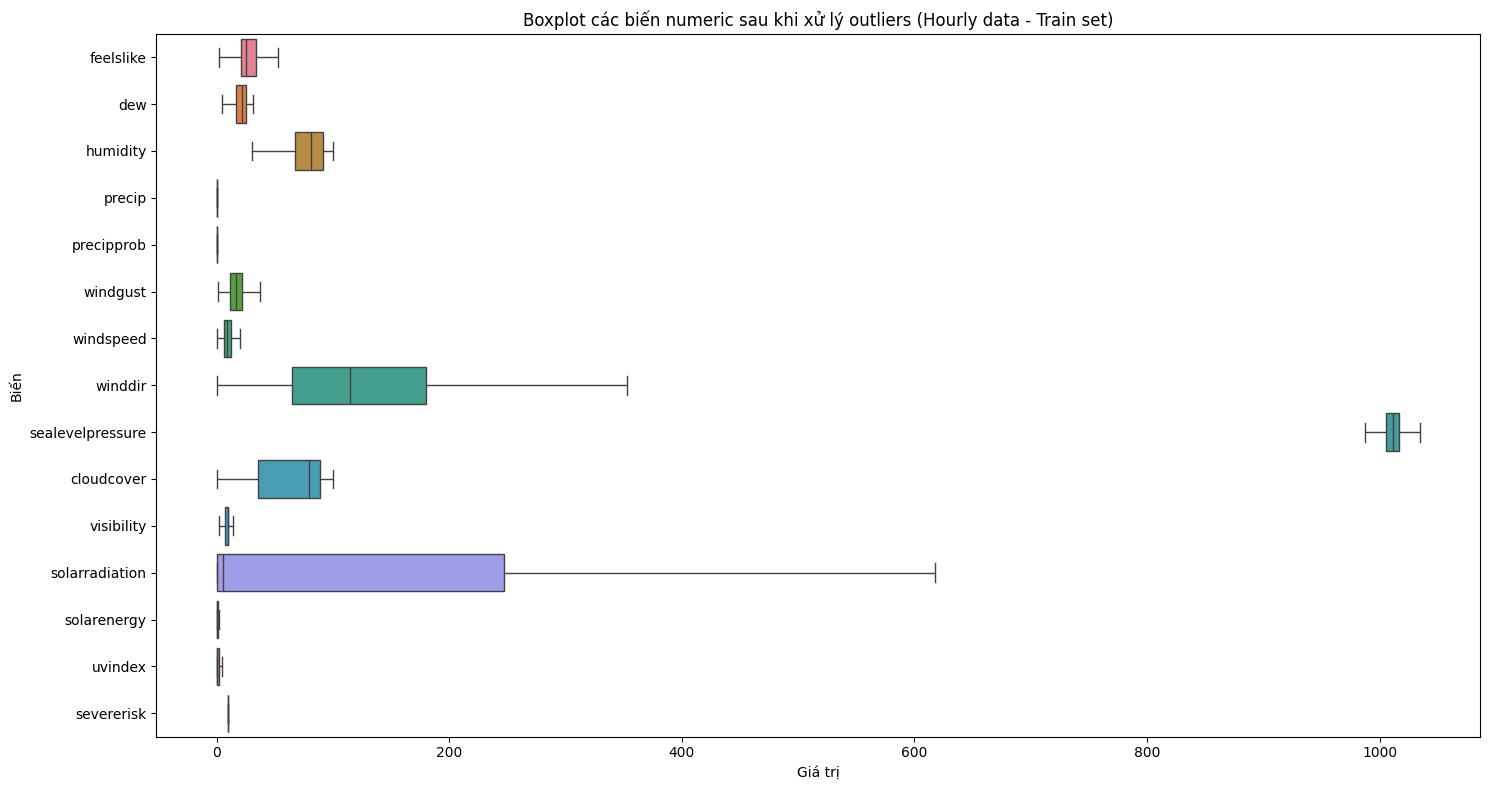

In [36]:
# Chọn toàn bộ cột numeric
numeric_cols = X_train_h_capped.select_dtypes(include=[np.number]).columns

# Vẽ boxplot cho tất cả biến numeric (sau xử lý outliers)
plt.figure(figsize=(15, 8))
sns.boxplot(data=X_train_h_capped[numeric_cols], orient='h', showfliers=False)
plt.title("Boxplot các biến numeric sau khi xử lý outliers (Hourly data - Train set)")
plt.xlabel("Giá trị")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

In [37]:
# Correlation matric
corr = df_hourly.corr(numeric_only=True)
print(corr)

                      temp  feelslike       dew  humidity    precip  \
temp              1.000000   0.963668  0.793498 -0.195288  0.008059   
feelslike         0.963668   1.000000  0.780998 -0.171755 -0.002804   
dew               0.793498   0.780998  1.000000  0.435492  0.043367   
humidity         -0.195288  -0.171755  0.435492  1.000000  0.061424   
precip            0.008059  -0.002804  0.043367  0.061424  1.000000   
precipprob        0.043853   0.035472  0.086414  0.072175  0.274176   
windgust          0.205252   0.176198  0.053895 -0.218298  0.033686   
windspeed         0.088959   0.088346  0.008403 -0.129585 -0.016352   
winddir           0.074593   0.055246  0.016532 -0.078726  0.022063   
sealevelpressure -0.816868  -0.813780 -0.837978 -0.151234 -0.050082   
cloudcover       -0.119108  -0.120157 -0.000681  0.169233  0.056437   
visibility        0.346025   0.361043  0.067159 -0.422959 -0.002736   
solarradiation    0.448334   0.437110  0.076759 -0.528611 -0.029210   
solare

In [38]:
#Xử lí text
numeric_cols = ["tempmax", "tempmin", "temp", "dew", "windspeed", "windgust", "pressure"]
categorical_cols_existing = ["conditions"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols_existing)
    ],
    remainder='passthrough' 
)

In [39]:
# Save the processed data
save_dir = '../data/processed/'
train_data_h.to_excel(save_dir + 'train_data_h.xlsx', index=False)
test_data_h.to_excel(save_dir + 'test_data_h.xlsx', index=False)
X_train_h_capped.to_excel(save_dir + 'X_train_h.xlsx', index=False)
y_train_h.to_excel(save_dir + 'y_train_h.xlsx', index=False)
X_test_h_capped.to_excel(save_dir + 'X_test_h.xlsx', index=False)
y_test_h.to_excel(save_dir + 'y_test_h.xlsx', index=False)